-------
#Lecture 24: Supervised Machine Learning (Part 4)
-------

We'll cover:
1. Decision Trees
2. Random Forest
3. K-Means Clustering (Unsupervised Machine Learning)


##Decision Trees

Using the famous Iris dataset, we use scikit-learn's `tree` module and import the `DecisionTreeClassifier`class to build our first Decision Tree Classifier object.

Note: In the slides, I set the `random_state` to 0. If you want to reproduce the tree in the slides, set `random_state` to 0, and rerun.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = 2)
clf = DecisionTreeClassifier().fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.95


### Setting max decision tree depth to help avoid overfitting

We can see the effect of pre-pruning by setting `max_depth` to three on the iris dataset. Now the accuracy on the training data is slightly worse but the accuracy on the test data is slightly better. 

In [ ]:
clf2 = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf2.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf2.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.98
Accuracy of Decision Tree classifier on test set: 0.97


### Visualizing decision trees

One great advantage of decision trees at least for the not too big, is that they're easy to interpret. Visualizing the entire tree can show you exactly how the decision tree is making its predictions.

Below is a useful function that you can use to visualize decision trees. (Credit to: `adspy_shared_utilities.py` code)

What it does is that it takes the classifier object, the feature names, and the class names as input, then uses the `graphviz` library to visualize the tree. It works by calling the `export_graphviz` function in the `sklearn.tree` module to create a dot file which is a text file description of the tree, and then using the `graphviz` library to visualize the dot file and create an image. 

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

def plot_decision_tree(clf, feature_names, class_names):
    # This function requires the pydotplus module and assumes it's been installed.
    # In some cases (typically under Windows) even after running conda install, there is a problem where the
    # pydotplus module is not found when running from within the notebook environment.  The following code
    # may help to guarantee the module is installed in the current notebook environment directory.
    #
    # import sys; sys.executable
    # !{sys.executable} -m pip install pydotplus

    export_graphviz(clf, out_file="adspy_temp.dot", feature_names=feature_names, class_names=class_names, filled = True, impurity = False)
    with open("adspy_temp.dot") as f:
        dot_graph = f.read()
    # Alternate method using pydotplus, if installed.
    # graph = pydotplus.graphviz.graph_from_dot_data(dot_graph)
    # return graph.create_png()
    return graphviz.Source(dot_graph)

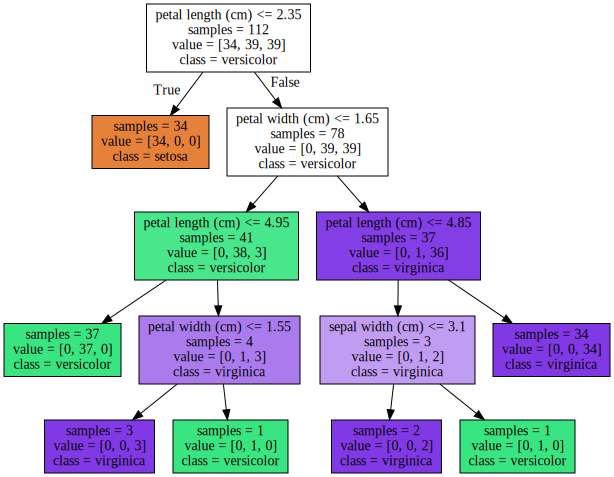

In [ ]:
plot_decision_tree(clf, iris.feature_names, iris.target_names)

###Feature Importance

In scikit-learn, feature importance values are stored as a list in an estimated property called `feature_importances_`. Note the underscore at the end of the name indicates it's a property of the object that's set as a result of fitting the model and not as a user defined property. 

In the code below, we plot feature importances as a horizontal bar chart with the features listed along the y axis by name and the feature importance along the x axis. 

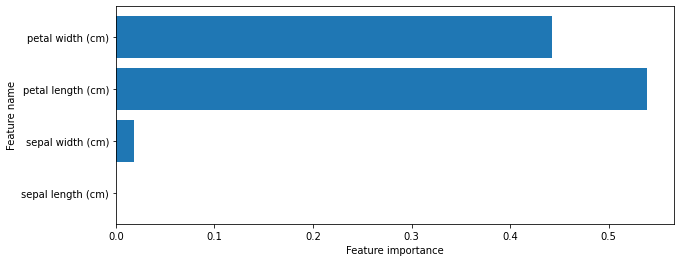

Feature importances: [0.         0.0178928  0.53935321 0.44275399]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

plt.figure(figsize=(10,4))
plot_feature_importances(clf, iris.feature_names)
plt.show()

print('Feature importances: {}'.format(clf.feature_importances_))

###Decision boundaries across different pairs of features

The code below shows you the division of the different classes across different pairs of features in the iris dataset, for a decision tree of depth 4.

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)

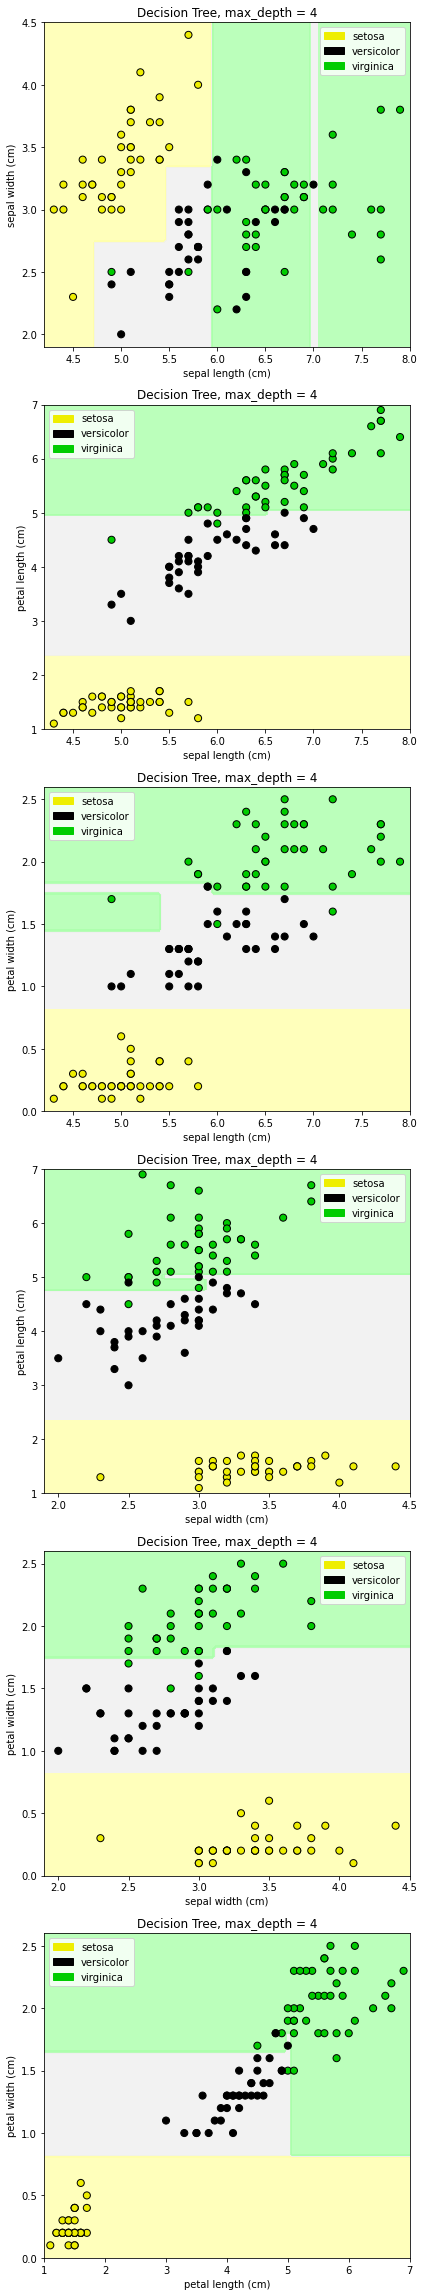

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = 0)
fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]
tree_max_depth = 4

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    clf = DecisionTreeClassifier(max_depth=tree_max_depth).fit(X, y)
    title = 'Decision Tree, max_depth = {:d}'.format(tree_max_depth)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             iris.target_names)
    
    axis.set_xlabel(iris.feature_names[pair[0]])
    axis.set_ylabel(iris.feature_names[pair[1]])
    
plt.tight_layout()
plt.show()

###Decision Trees on a Real World Dataset

Finally let's apply decision trees to the breast cancer data set that we've been using across multiple supervised learning algorithms. We control the complexity by setting the `max_depth` and `min_samples_leaf` parameters, and include the visualization of the resulting tree followed by a feature importance plot. 

As an exercise, try removing these two parameters and just use the default settings to see the effect on test set accuracy and the increase in overfitting that occurs. For this training set, the mean concave points feature gives the most informative initial split, followed by the worst area parameter. 

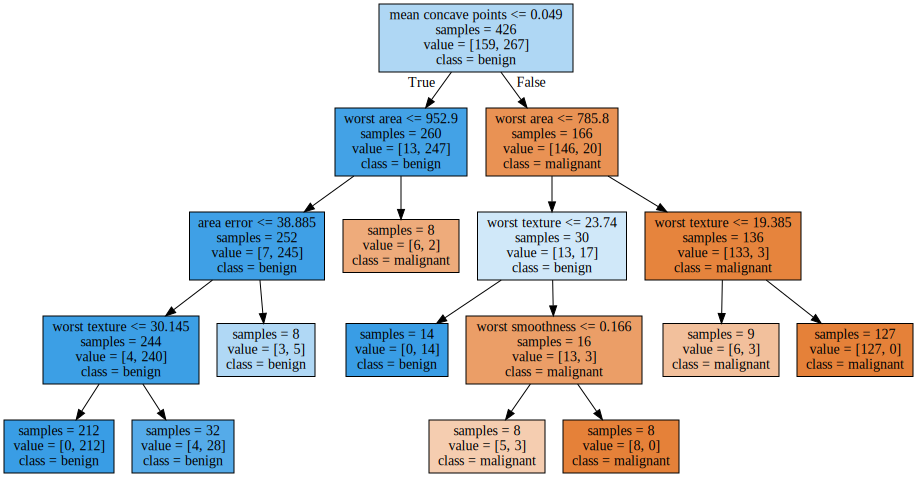

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 8, random_state = 0).fit(X_train, y_train)

plot_decision_tree(clf, cancer.feature_names, cancer.target_names)

Breast cancer dataset: decision tree
Accuracy of DT classifier on training set: 0.96
Accuracy of DT classifier on test set: 0.94


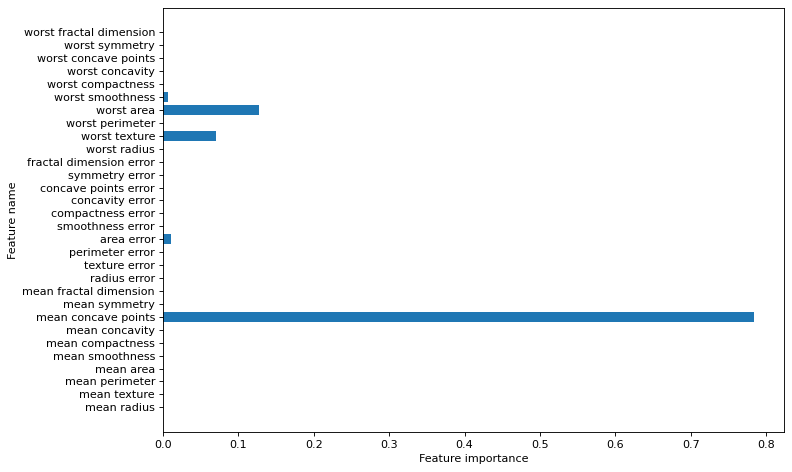

In [ ]:
print('Breast cancer dataset: decision tree')
print('Accuracy of DT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

plt.figure(figsize=(10,6),dpi=80)
plot_feature_importances(clf, cancer.feature_names)
plt.tight_layout()

plt.show()

##Ensemble of Decision Trees

###Random Forests

For this example, we generate a synthetic dataset for classification (binary) where classes that are not linearly separable

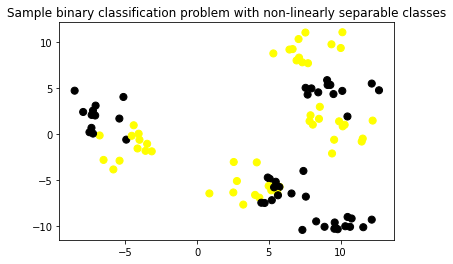

In [ ]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

X_D2, y_D2 = make_blobs(n_samples = 100, n_features = 2,
                       centers = 8, cluster_std = 1.3,
                       random_state = 4)
y_D2 = y_D2 % 2
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_D2[:,0], X_D2[:,1], c=y_D2,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

The code below shows you how to run a Random Forest Classifier. 

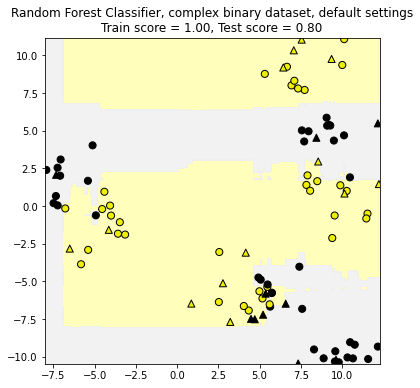

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2,random_state = 0)

fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))

clf = RandomForestClassifier().fit(X_train, y_train)
title = 'Random Forest Classifier, complex binary dataset, default settings'
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, X_test, y_test, title, subaxes)

plt.show()

###Random Forest on the Fruit Dataset

Let's take a look at how to create and visualize the Random Forest model on the fruit dataset. This code plots the decision boundaries for all possible feature pairs. 

Similar to the code above, we use the `RandomForestClassifier` class from the `sklearn.ensemble` library. After doing the usual `train_test_split`, we iterate through pairs of feature columns in the dataset. For each pair of features we call the `fit()` method on that subset of the training data `X` using the labels `y`. We then use the `plot_class_regions_for_classifier_subplot` function to visualize the training data and the random forest decision boundaries.

You can see that the decision boundaries overall have the box like shape that we associate with decision trees but with some additional detail variation to accommodate specific local changes in the training data.


In [ ]:
# Mount the drive. 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


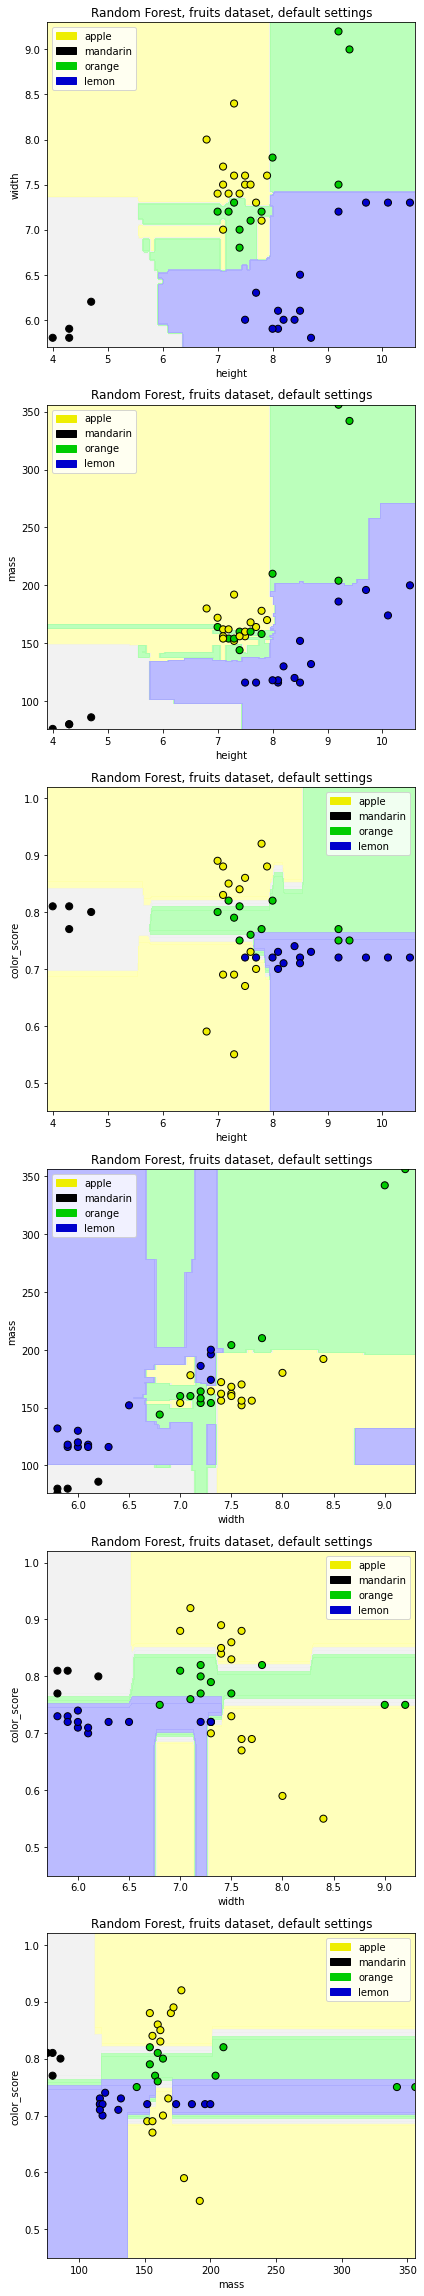

Random Forest, Fruit dataset, default settings
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.80


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fruits = pd.read_csv('/content/drive/My Drive/Applied Data Science in Python/datasets/fruit_data_with_colors.csv', sep="\t")

feature_names_fruits = ['height', 'width', 'mass', 'color_score']
X_fruits = fruits[feature_names_fruits]
y_fruits = fruits['fruit_label']
target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

X_train, X_test, y_train, y_test = train_test_split(X_fruits.values,y_fruits.values,random_state = 0)

fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

title = 'Random Forest, fruits dataset, default settings'
pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    clf = RandomForestClassifier().fit(X, y)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,None, title, axis,target_names_fruits)
    
    axis.set_xlabel(feature_names_fruits[pair[0]])
    axis.set_ylabel(feature_names_fruits[pair[1]])
    
plt.tight_layout()
plt.show()

clf = RandomForestClassifier(n_estimators = 10,random_state=0).fit(X_train, y_train)

print('Random Forest, Fruit dataset, default settings')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

###Random Forest on a Real World Dataset

Finally, let's apply Random Forest to a larger dataset with more features. For comparison with other supervised learning methods, let's re-use the breast cancer dataset. 

We create a new `RandomForestClassifier` and since there are about 30 features, we'll set `max_features` to eight to give a diverse set of trees that also fit the data reasonably well. 

We can see that Random Forest with no feature scaling or extensive parameter tuning achieve very good test set performance on this dataset, in fact, it's as good or better than all the other supervised methods we've seen so far including Support Vector Machines that require more careful tuning.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = RandomForestClassifier(max_features = 8, random_state = 0)
clf.fit(X_train, y_train)

print('Breast cancer dataset')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Breast cancer dataset
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.97


##K-Means Clustering

This example creates an artificial dataset with `make_blobs`, then applies k-means to find 3 clusters, and plots the points in each cluster identified by a corresponding color.

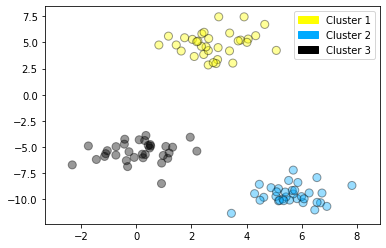

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()

X, y = make_blobs(random_state = 10)

kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)

plot_labelled_scatter(X, kmeans.labels_, ['Cluster 1', 'Cluster 2', 'Cluster 3'])

After fitting the model, we can access our data classification and centroid coordinates using the `labels_` and `clusters_centers_`.

In [ ]:
kmeans.cluster_centers_

array([[ 2.84050716,  4.85840422],
       [ 5.6183469 , -9.54288499],
       [ 0.08921213, -5.46441742]])

In [ ]:
kmeans.labels_

array([2, 2, 0, 1, 0, 0, 1, 2, 0, 1, 1, 0, 0, 2, 2, 0, 1, 0, 1, 0, 1, 2,
       0, 2, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 2, 0, 0, 0, 2, 1, 2, 2,
       0, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 0, 0, 2, 2, 2, 1,
       1, 2, 2, 2, 0, 1, 0, 0, 2, 0, 0, 2, 1, 1, 1, 0, 1, 0, 2, 0, 2, 1,
       2, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1], dtype=int32)

###Choosing K with the Elbow Method

The one part missing from our understanding of K-Means is how to choose K?

By far, the most popular approach is the **Elbow Method**. Fortunately, it's incredibly simple too.

First, we need to run our algorithm with some value of K -- once complete, we can pull the sum of squared error (SSE) for our X-values from the `inertia_` attribute.

In [ ]:
sse = kmeans.inertia_
sse

186.36588620101443

SSE is calculated as the sum of the squared distance between each datapoint and its allocated cluster centroid. If all data points are tightly congregated around their allocated centroid, then the SSE will be low -- otherwise, it will be high.

It is important that we have enough clusters to match the clusters in our dataset, but not too many clusters than the SSE is minimized simply by assigning every datapoint it's own cluster.

In [ ]:
sse = []
k = []

for K in range(1,10):
  kmeans = KMeans(n_clusters=K)
  kmeans.fit(X)
  k.append(K)
  sse.append(kmeans.inertia_)

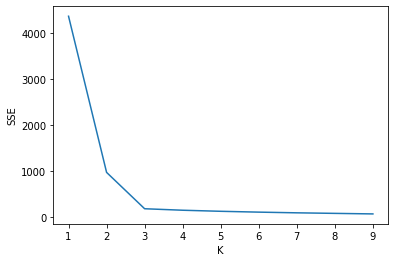

In [ ]:
import seaborn as sns

sns.lineplot(x=k,y=sse)
plt.xlabel('K')
plt.ylabel('SSE');

We need to find the magic spot where we correctly identify the most logical number of clusters. This spot can be identified by calculating the SSE for a range of K values and identifying the "elbow" in the graph shown above.

In this case K=3 is an obvious good option.

